# Predicting Project Costs in UK Public Sector

## 1. Motivation & Background Knowledge about Projects in UK Public Sector

this is text

## 2. Getting the Data & EDA

The data is retrieved through https://www.gov.uk/government/collections/major-projects-data that collects data from 2012-2022 about the progress of projects in the Government Major Projects Portfolio. For each year we can download a `.csv` file and after downloading all of them, we compare the columns in order to merge them together. These are stored in the folder `raw_data`.

### 2.1 Importing Libraries

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.datasets import make_regression
from xgboost import XGBRegressor
from bayes_opt import BayesianOptimization
from hyperopt import hp, fmin, tpe

### 2.2 Preparing & Merging `.csv` files into a Dataframe

As we found out, the column names have been changed throughout the years and in order to merge the yearly file into one in the end, we first need to ensure the correct naming. We did this actually in Excel before loading the files into the Dataframe.

!!! We need to transpose some first and save them again

In [4]:
# Initializing a Dicitionary to load and save the Dataframes
dataframes = {}

# Defining the path from which to load the .csv files
base_path = '../data/raw_data/uk_'
years = range(2014, 2024)

# Function to load .csv files with different delimiters as we have different ones in the files
def load_csv_with_fallback(file_path):
    try:
        df = pd.read_csv(file_path, encoding='iso-8859-2', delimiter=';')
        return df
    except pd.errors.ParserError:
        return pd.read_csv(file_path, encoding='iso-8859-2', delimiter=',')

# Loading .csv files into Dataframe and save into Dictionary
for year in years:
    file_path = f'{base_path}{year}.csv'
    df_name = f'df_{year}'
    dataframes[df_name] = load_csv_with_fallback(file_path)

After loading the `.csv` files into separate Dataframes, we can merge them by concatinating as we also see that latest datasets have more columns.

In [7]:
# Function that merges the dataframes to one dictionary
def merge_dataframes(dataframes_dict):
    # Extracting all DataFrames from the dictionary and saving them as list
    df_list = list(dataframes_dict.values())
    
    # Concetinating all Dataframes to one
    merged_df = pd.concat(df_list, ignore_index=True)
    
    return merged_df

# Calling the function to merge all Dataframes
df = merge_dataframes(dataframes)

### 2.3 Data Cleaning

We initially find two columns for the colour rating but per instance only one of them contains the needed information. So we combine these into one final column for the colour rating.

In [8]:
df['colour_rating_new'] = df['colour_rating'].combine_first(df['colour_rating.1'])
df = df.drop(columns=['colour_rating', 'colour_rating.1'])

C:\Users\fraus\AppData\Local\Temp\ipykernel_17112\2742557625.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['colour_rating_new'] = df['colour_rating'].combine_first(df['colour_rating.1'])


Additionally, there is some text or symbols that needs to be removed from numeric columns. We start with removing the currency symbol.

In [ ]:
# List of columns where the currency symbol needs to be removed
columns_to_replace = [
    'wlc_baseline_incl_NCG',
    'total_baseline',
    'forecast_incl_NGC',
    'yearly_forecast',
    'TOTAL Baseline Benefits (Łm)'
]

# Loop for removal of the sign
for column in columns_to_replace:
    df[column] = df[column].str.replace('Ł', '', regex=False)

Next, we remove the ',' from the numeric columns that have a 1.000-separator and make sure, the values are in float format so we can process them as numbers.

In [ ]:
# Defining a function for the process
def process_value(value):
    # Trying to convert the value into a float
    try:
        float(value)
        return value
    except ValueError:
        pass
    
    # Second step: Replace ',' with '' and try again to convert into float
    try:
        value = value.replace(',', '')
        float(value)
        return value
    except (ValueError, AttributeError):
        return np.nan

# Using the function to process various columns at once
columns_to_process = ['total_baseline', 'forecast_incl_NGC', 'wlc_baseline_incl_NCG', 'TOTAL Baseline Benefits (Łm)', 'yearly_forecast']
df[columns_to_process] = df[columns_to_process].applymap(process_value)


Furthermore, 

### 2.4. Imputing data

missing dates, missing benefits etc --> use correct pickle/df

In [33]:
# Tabular Overview
df.isnull().sum()

project_name                                     1
description_aims                                 4
rating_comment                                   5
start_date                                     147
end_date                                       111
                                              ... 
grants_and_other_revenue                         1
forecast_variance_prev_year                      0
forecast_variance_budget                       193
forecast_percentage_change_prev_year_filled    807
forecast_pred                                  136
Length: 63, dtype: int64

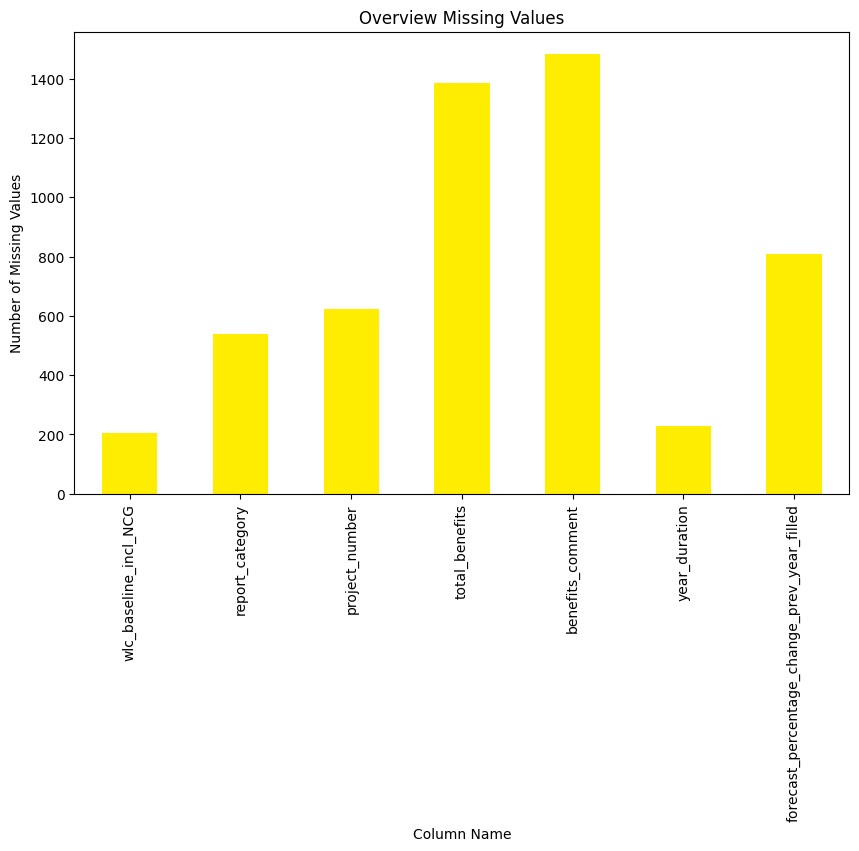

In [34]:
# Plot view for Presentation
missing_values = df.isnull().sum()

missing_values_filtered = missing_values[missing_values > 200]

# If needed, filtered Dataframe can be saved as .csv for later usage
# missing_values_filtered.to_csv('missing_values_filtered.csv', index=True)

plt.figure(figsize=(10, 6))
missing_values_filtered.plot(kind='bar', color='#ffed00')
plt.title('Overview Missing Values')
plt.xlabel('Column Name')
plt.ylabel('Number of Missing Values')
plt.show()

### 2.5 EDA

After cleaning the data, we can start the EDA process in order to get a deeper understanding of what we can get out of the dataset. We start with reading the saved `.pkl` file into a Dataframe.

In [8]:
df = pd.read_pickle('../data/pickle/final_pickle.pkl')

Get an overview of basic statistical data:

In [9]:
df.describe()

,start_date,end_date,yearly_budget,yearly_forecast,wlc_baseline_incl_NCG,year,total_benefits,year_duration,start_year,end_year,GDP,annual_earning_ft,unemployment_rate,youth_unemployment_rate,inflation_rate,population,gov_debt,tax_revenue,revenue_excl_grants,grants_and_other_revenue
count,1581,1617,1590.000000,1592.000000,1522.000000,1727.000000,343.000000,1501.000000,1581.000000,1617.000000,1.727000e+03,1727.000000,1727.000000,1727.000000,1727.000000,1.727000e+03,1.727000e+03,1.727000e+03,1.727000e+03,1727.000000
mean,2013-06-27 19:25:50.664136704,2023-02-02 02:50:58.998144512,187.026111,173.418413,2431.478031,2018.756225,7535.046443,9.454024,2013.065149,2022.572665,2.121425e+06,29666.069485,0.049415,0.136985,0.040455,6.613524e+07,3.394444e+07,5.418678e+06,7.233278e+06,449797.556456
min,1987-11-06 00:00:00,2011-10-18 00:00:00,-2.700000,-2.700000,0.000000,2014.000000,-30.690000,-0.080000,1987.000000,2011.000000,1.963807e+06,27011.000000,0.037300,0.105100,0.008000,6.412827e+07,2.523179e+07,4.474700e+06,6.000330e+06,387990.000000
25%,2011-02-28 00:00:00,2018-03-31 00:00:00,12.512500,11.042500,105.537500,2016.000000,402.000000,4.360000,2011.000000,2018.000000,2.026566e+06,27615.000000,0.040000,0.111900,0.018000,6.511622e+07,2.835378e+07,4.800640e+06,6.337520e+06,397590.000000
50%,2013-07-07 00:00:00,2022-05-31 00:00:00,45.135000,39.572938,379.835000,2019.000000,2202.000000,6.930000,2013.000000,2022.000000,2.167415e+06,29559.000000,0.048100,0.127700,0.027000,6.646034e+07,3.404150e+07,5.327300e+06,7.094560e+06,441770.000000
75%,2016-09-01 00:00:00,2025-04-30 00:00:00,152.525000,132.247500,1499.615000,2022.000000,6418.000000,12.070000,2016.000000,2025.000000,2.197841e+06,31285.000000,0.053000,0.145100,0.060000,6.702629e+07,3.581471e+07,6.032310e+06,8.017930e+06,457920.000000
max,2023-02-20 00:00:00,2075-12-31 00:00:00,12445.000000,11988.150000,55700.000000,2023.000000,70638.000000,67.500000,2023.000000,2075.000000,2.270764e+06,33061.000000,0.075200,0.205000,0.092000,6.779100e+07,4.267850e+07,6.842110e+06,9.215550e+06,598780.000000
std,NaN,NaN,551.115080,524.738620,6000.761737,3.115428,14184.934940,7.842324,4.965469,7.037018,1.032359e+05,2108.201281,0.011670,0.030452,0.028107,1.210110e+06,5.718777e+06,7.470146e+05,1.025102e+06,64632.417671


Besides obvious errors as negative budgets, forecasts and length of project, we can also derive meaningful information from this overview such as
- Average yearly budgets are £187B whereas average yearly forecasts are £14B (-8%) lower.
- Throughout the entire project lifetime, the average costs for a project are £2.431B. If we calculate a yearly average from there, we see an even higher yearly forecast with £255B. This leads to the hypothesis of underbudgeting projects.
- Average project length is 9.5 years.
- The dataset includes projects with a lifespan between 1987-2075.

#### 2.5.1 Errors in the Dataset

Investigating on negative budget/forecast values:

In [10]:
# Filter rows where yearly_budget or yearly_forecast is negative
negative_values = df[(df['yearly_budget'] < 0) | (df['yearly_forecast'] < 0)]

pd.set_option('display.max_colwidth', None)
# Display the result
print(negative_values)

                 project_name   
1080  The Tate Modern Project  \

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        description_aims   
1080  The project aims to create more space to welcome people and to create a wide range of high quality social spaces where people can c

Only one project has negative values for yearly budget/forecast and we can assume, that this is an error and should be positive. By using the Pandas function `.abs()` we convert them to positive numbers.

In [11]:
df['yearly_budget'] = df['yearly_budget'].abs()
df['yearly_forecast'] = df['yearly_forecast'].abs()

Investigating on negative benefits values:

In [12]:
# Filter rows where total_benefits is negative
negative_benefits = df[(df['total_benefits'] < 0)]

pd.set_option('display.max_colwidth', None)
# Display the result
print(negative_benefits)
print(negative_benefits[['total_benefits']])

                                    project_name   
10   Workplace Services Transformation Programme  \
469  Workplace Services Transformation Programme   
634  Workplace Services Transformation Programme   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       description_aims   
10   The Workplace Services Transformation Programme seeks to build and run workplace services that can grow to meet demand and flex in response to goverments needs and the growth of the GPA property portfolio. The programme will promote productivity a

3 instances from 1 project have negative values for benefits and we can assume, that this is an error and should be positive. By using the Pandas function `.abs()` we convert them to a positive number.

In [13]:
df['total_benefits'] = df['total_benefits'].abs()

Investigating on negative year values:

In [14]:
# Filter rows where year_duration is negative
negative_years = df[(df['year_duration'] < 0)]

pd.set_option('display.max_colwidth', None)
# Display the result
print(negative_years)
print(negative_years[['year_duration']])

                          project_name   
176  European Common Radar System Mk 2  \

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            description_aims   
176  The Phase 4 En

Also here only one project is affected by errors during the collection of the data. Let's see, if we can find other data from other years for that project to calculate correct the correct length.

In [15]:
# Filter rows for the project name
project_wrong_length = df[(df['project_name'] == 'European Common Radar System Mk 2')]

pd.set_option('display.max_colwidth', None)
# Display the result
print(project_wrong_length)

                          project_name   
176  European Common Radar System Mk 2  \
308  European Common Radar System Mk 2   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         

So we can actually see, that the correct end date is set to 01-01-2040 and we can impute this to the wrong instance instead.

In [16]:
# Convert the correct value to a datetime object
correct_value = pd.to_datetime('2040-01-01')

# Impute the correct value at index 176 for the column 'end_date'
df.at[176, 'end_date'] = correct_value

# Verify the change
print(df.loc[176, 'end_date'])


2040-01-01 00:00:00


In [17]:
df = pd.read_pickle('../data/pickle/final_wo_errors.pkl')

#### 2.5.2 Plotting the Dataset

Creating a Plot to show Development of Number of Projects per Year

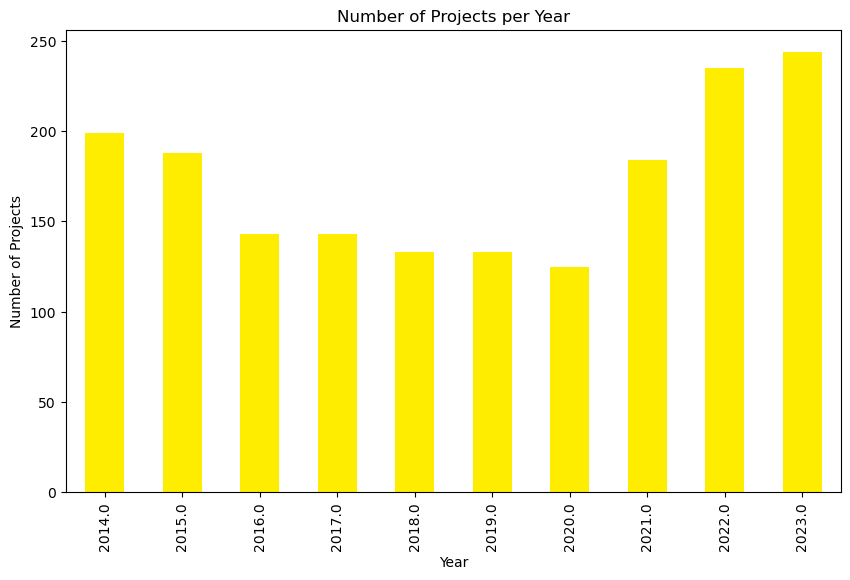

In [18]:
projects_per_year = df.groupby('year')['project_name'].count()

# If needed, filtered Dataframe can be saved as .csv for later usage
# projects_per_year.to_csv('projects_per_year.csv', index=True)

plt.figure(figsize=(10, 6))
projects_per_year.plot(kind='bar', color='#ffed00')
plt.title('Number of Projects per Year')
plt.xlabel('Year')
plt.ylabel('Number of Projects')
plt.show()

Creating a Plot to show Development of Number of Projects per Year and Category

<Figure size 1200x800 with 0 Axes>

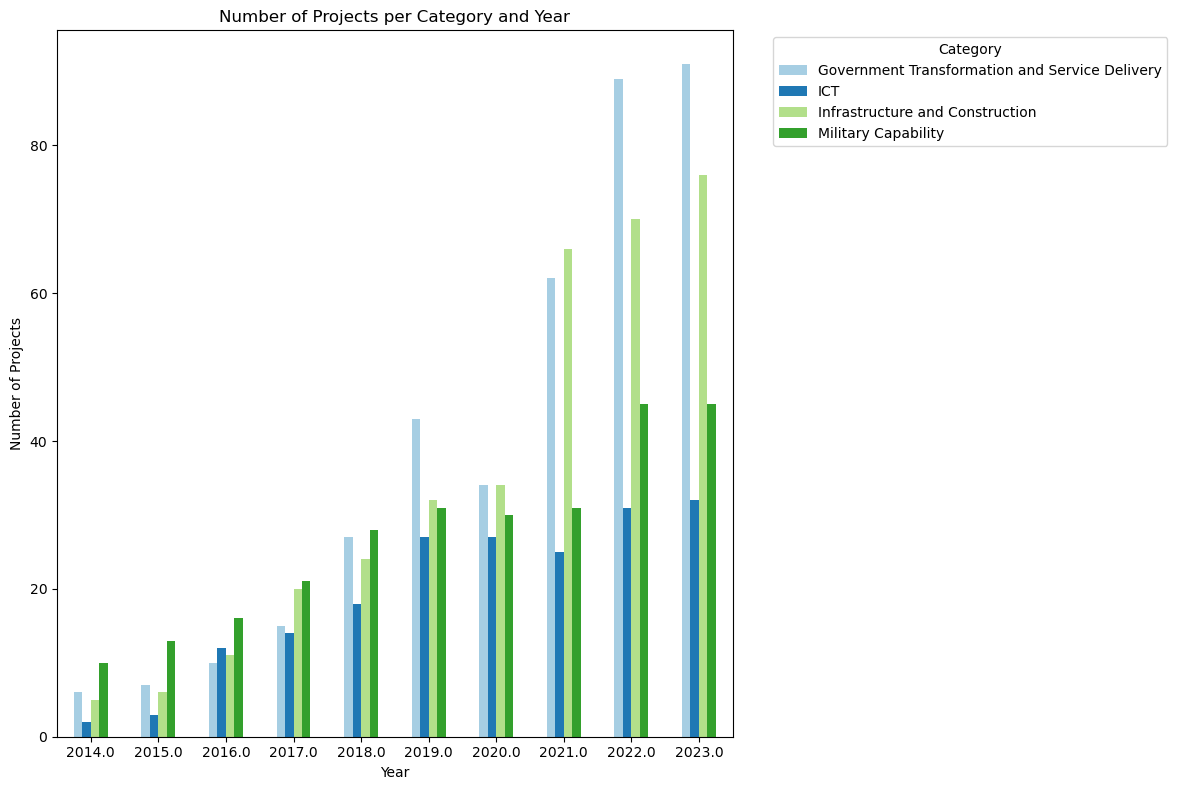

In [19]:
projects_per_year_category = df.groupby(['year', 'report_category'])['project_name'].count().unstack()

plt.figure(figsize=(12, 8))
projects_per_year_category.plot(kind='bar', stacked=False, color=plt.cm.Paired.colors, figsize=(12, 8))

# If needed, filtered Dataframe can be saved as .csv for later usage
# projects_per_year_category.to_csv('projects_per_year_category.csv', index=True)


plt.title('Number of Projects per Category and Year')
plt.xlabel('Year')
plt.ylabel('Number of Projects')
plt.xticks(rotation=0)

plt.legend(title='Category', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

Overview of Cost Allocation as Boxplot

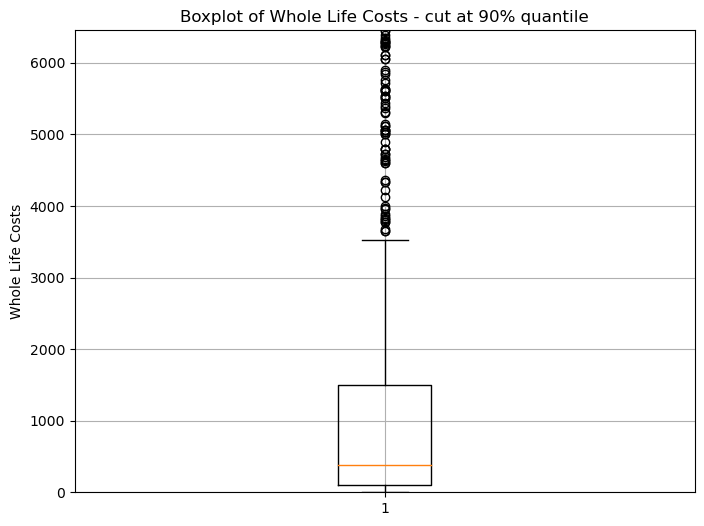

In [20]:
plt.figure(figsize=(8, 6))
plt.boxplot(df['wlc_baseline_incl_NCG'].dropna())

plt.ylim(0, df['wlc_baseline_incl_NCG'].quantile(0.90))

plt.title('Boxplot of Whole Life Costs - cut at 90% quantile')
plt.ylabel('Whole Life Costs')
plt.grid(True)
plt.show()

Create a Correlation Matrix

We can only create Correlation Matrices for numeric values, therefore we first need to remove text columns.

In [21]:
num_columns = df.select_dtypes(exclude=['object']).columns.tolist()

In [22]:
text_columns = df.select_dtypes(include=['object']).columns.tolist()

In [23]:
# Convert all boolean columns to numeric (1 for True, 0 for False)
df = df.applymap(lambda x: int(x) if isinstance(x, bool) else x)

In [24]:
df_numeric = df.drop(columns=text_columns)

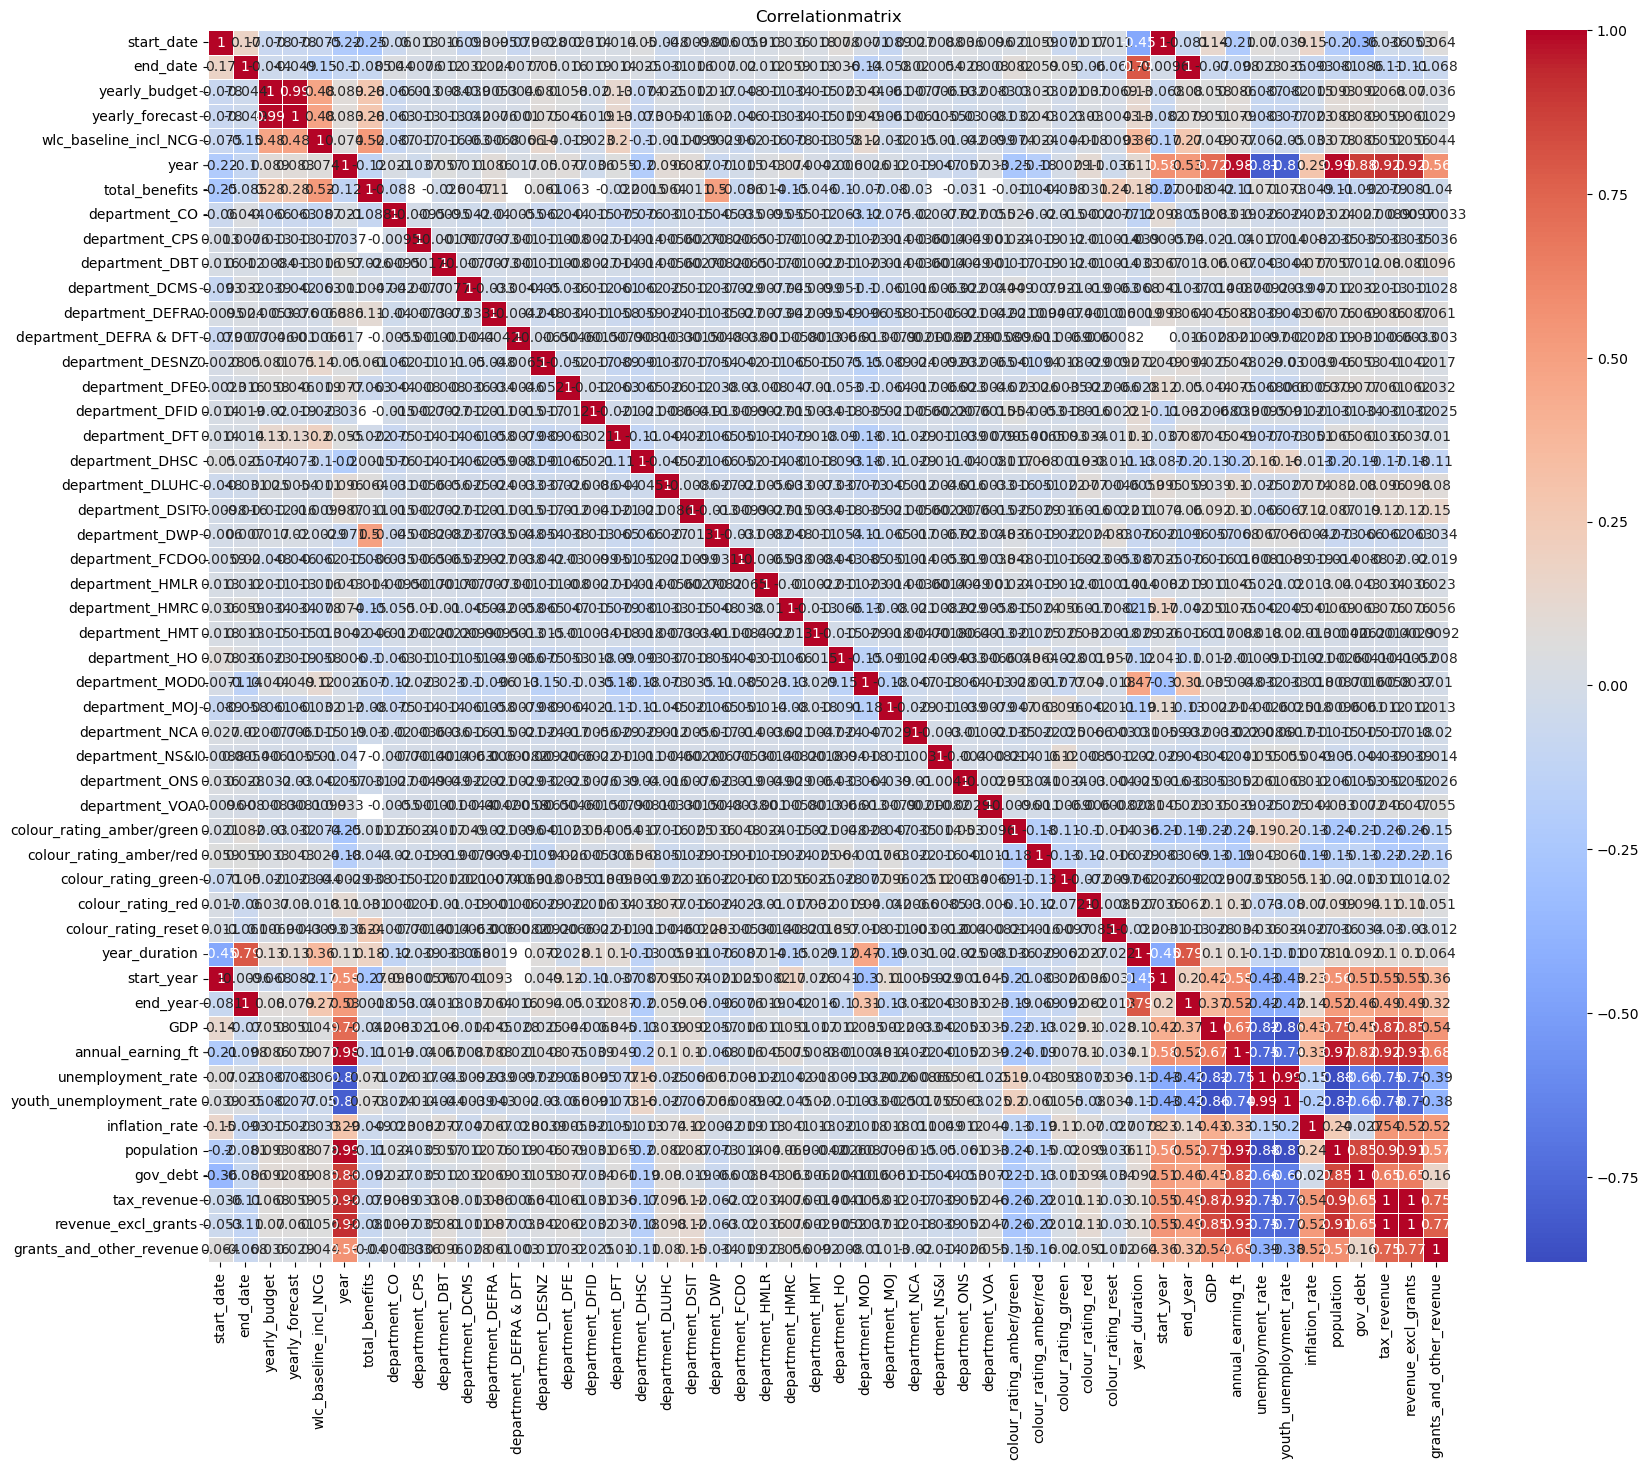

In [25]:
corr_matrix = df_numeric.corr()

plt.figure(figsize=(20, 16))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)

plt.title('Correlationmatrix')
plt.show()

## 3. Baseline Models

### 3.0 Preparation

In [26]:
# Sorting the DataFrame by 'project_name' and 'year'
df.sort_values(by=['project_name', 'year'], inplace=True)

In [27]:
# Calculating Forecast Variance (Yearly Forecast - Previous Yearly Forecast)
df['forecast_variance_prev_year'] = df.groupby('project_name')['yearly_forecast'].pct_change() * 100

# Calculating Budget Variance (Yearly Forecast - Yearly Budget)
df['forecast_variance_budget'] = ((df['yearly_forecast'] - df['yearly_budget']) / df['yearly_budget']) * 100

In [28]:
# Calculate the percentage change trend for each project
df['forecast_percentage_change_prev_year_filled'] = df.groupby('project_name')['forecast_variance_prev_year'].fillna(method='ffill')

In [29]:
df['forecast_variance_prev_year'].fillna(0, inplace=True)

### 3.1 Last Observation Carried Forward (LOCF)

remove NaNs, calculate RMSE

In [30]:
# LOCF baseline-model for costs (Forecast) based on £
# Approach: We are taking the last two instances

# Creating the predicted values based on the LOCF-method
df['forecast_pred'] = df['yearly_forecast'].shift(1)

# There is no previous value for the first entry, so the predicted value remains NaN
# The model ignores the first entry as it has no previous point

# Calculating the errors for the baseline model
mse_forecast = mean_squared_error(df['yearly_forecast'].iloc[1:], df['forecast_pred'].iloc[1:])

print(f"LOCF forecast MSE: {mse_forecast}")


ValueError: Input contains NaN.

In [31]:
# LOCF baseline-model for costs (Forecast) based on %
# Approach: We are taking the last two instances

# Creating the predicted values based on the LOCF-method
df['forecast_pred_percentage'] = df['forecast_variance_prev_year'].shift(1)

# There is no previous value for the first entry, so the predicted value remains NaN
# The model ignores the first entry as it has no previous point

df['forecast_pred_percentage'].fillna(0, inplace=True)
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.fillna(0, inplace=True)

# Calculating the errors for the baseline model
mse_forecast = mean_squared_error(df['forecast_variance_prev_year'].iloc[1:], df['forecast_pred_percentage'].iloc[1:])

print(f"LOCF forecast MSE: {mse_forecast}")

LOCF forecast MSE: 79384169.84765208


### 3.2 Calculating Forecast based on Variance Percentage Trend

In [32]:
# Calculate the last known forecast value and the trend of the percentage change
last_forecast = df.groupby('project_name').last()['yearly_forecast']
last_percentage_change = df.groupby('project_name').last()['forecast_percentage_change_prev_year_filled']

# Calculating forecast for 2024
predicted_forecast_2024 = last_forecast * (1 + last_percentage_change / 100)

# Creating new DataFrame including 2024 data
df_2024 = pd.DataFrame({
    'project_name': last_forecast.index,
    'year': 2024,
    'predicted_forecast': predicted_forecast_2024
})

accuracy/MSE calculate based on past years

### 3.3 Mean/Median Predictor

In [33]:
# Calculating mean of 'forecast_variance_prev_year'
mean_forecast = df['forecast_variance_prev_year'].mean()

# Berechne den Median der Spalte 'yearly_forecast'
median_forecast = df['forecast_variance_prev_year'].median()

# Erstelle Vorhersagen für ein neues Jahr (z.B. 2024) basierend auf dem Mean und Median
df['mean_forecast_prediction'] = mean_forecast
df['median_forecast_prediction'] = median_forecast

# Optional: Ergebnisse für das nächste Jahr in einem neuen DataFrame
df_2024_1 = pd.DataFrame({
    'project_name': df['project_name'].unique(),
    'year': 2024,
    'predicted_forecast_mean': mean_forecast,
    'predicted_forecast_median': median_forecast
})

# Ergebnisse anzeigen
print(df_2024_1)

                                                      project_name  year   
0                                  10,000 Additional Prison Places  2024  \
1    10,000 Additional Prison Places Programme - Estate Expansions  2024   
2                                          100,000 Genomes Project  2024   
3                                           100000 Genomes Project  2024   
4         10K Additional Prison Places Estate Expansion Category D  2024   
..                                                             ...   ...   
728                                          Youth Investment Fund  2024   
729                                 Youth Justice Reform Programme  2024   
730                                 Youth Justice Reform programme  2024   
731                                                      care.data  2024   
732                                                              0  2024   

     predicted_forecast_mean  predicted_forecast_median  
0                 395.873273 

In [34]:
# Define train and test data
y_train = 
y_test = 

# Mean Predictor
mean_pred = np.mean(y_train)
y_pred_mean = np.full(y_test.shape, mean_pred)

# Median Predictor (optional)
median_pred = np.median(y_train)
y_pred_median = np.full(y_test.shape, median_pred)

# Berechnung der Fehlermetrik (z.B. Mean Squared Error)
mse_mean = mean_squared_error(y_test, y_pred_mean)
mse_median = mean_squared_error(y_test, y_pred_median)

print(f"Mean Predictor MSE: {mse_mean}")
print(f"Median Predictor MSE: {mse_median}")

SyntaxError: invalid syntax (2665618627.py, line 2)

## 4. Feature Engineering

duration, dummies, NLP

## 5. Preprocessing

scaling, pipelines

## 6. Modeling

### 6.1 Model 1: CATBoost

### 6.2 Model 2: XGBoost

Inital Model:

In [35]:
X = df.drop(columns=['wlc_baseline_incl_NCG'])
y = df['wlc_baseline_incl_NCG']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

xgb_reg = XGBRegressor(objective='reg:squarederror', random_state=42)

param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

grid_search = GridSearchCV(estimator=xgb_reg, param_grid=param_grid, scoring='neg_mean_squared_error', cv=5, verbose=1)

grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
best_score = grid_search.best_score_
print(f'Best Params: {best_params}')
print(f'Best negative MSE (Training): {best_score}')

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error (Test): {mse}')
rmse = np.sqrt(mse)
print(f'Root Mean Squared Error: {rmse}')

Fitting 5 folds for each of 108 candidates, totalling 540 fits


ValueError: 
All the 540 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
540 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/homebrew/Caskroom/miniconda/base/envs/capstone/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/homebrew/Caskroom/miniconda/base/envs/capstone/lib/python3.11/site-packages/xgboost/core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/opt/homebrew/Caskroom/miniconda/base/envs/capstone/lib/python3.11/site-packages/xgboost/sklearn.py", line 1081, in fit
    train_dmatrix, evals = _wrap_evaluation_matrices(
                           ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/homebrew/Caskroom/miniconda/base/envs/capstone/lib/python3.11/site-packages/xgboost/sklearn.py", line 596, in _wrap_evaluation_matrices
    train_dmatrix = create_dmatrix(
                    ^^^^^^^^^^^^^^^
  File "/opt/homebrew/Caskroom/miniconda/base/envs/capstone/lib/python3.11/site-packages/xgboost/sklearn.py", line 1003, in _create_dmatrix
    return QuantileDMatrix(
           ^^^^^^^^^^^^^^^^
  File "/opt/homebrew/Caskroom/miniconda/base/envs/capstone/lib/python3.11/site-packages/xgboost/core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/opt/homebrew/Caskroom/miniconda/base/envs/capstone/lib/python3.11/site-packages/xgboost/core.py", line 1573, in __init__
    self._init(
  File "/opt/homebrew/Caskroom/miniconda/base/envs/capstone/lib/python3.11/site-packages/xgboost/core.py", line 1632, in _init
    it.reraise()
  File "/opt/homebrew/Caskroom/miniconda/base/envs/capstone/lib/python3.11/site-packages/xgboost/core.py", line 569, in reraise
    raise exc  # pylint: disable=raising-bad-type
    ^^^^^^^^^
  File "/opt/homebrew/Caskroom/miniconda/base/envs/capstone/lib/python3.11/site-packages/xgboost/core.py", line 550, in _handle_exception
    return fn()
           ^^^^
  File "/opt/homebrew/Caskroom/miniconda/base/envs/capstone/lib/python3.11/site-packages/xgboost/core.py", line 637, in <lambda>
    return self._handle_exception(lambda: self.next(input_data), 0)
                                          ^^^^^^^^^^^^^^^^^^^^^
  File "/opt/homebrew/Caskroom/miniconda/base/envs/capstone/lib/python3.11/site-packages/xgboost/data.py", line 1416, in next
    input_data(**self.kwargs)
  File "/opt/homebrew/Caskroom/miniconda/base/envs/capstone/lib/python3.11/site-packages/xgboost/core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/opt/homebrew/Caskroom/miniconda/base/envs/capstone/lib/python3.11/site-packages/xgboost/core.py", line 617, in input_data
    new, cat_codes, feature_names, feature_types = _proxy_transform(
                                                   ^^^^^^^^^^^^^^^^^
  File "/opt/homebrew/Caskroom/miniconda/base/envs/capstone/lib/python3.11/site-packages/xgboost/data.py", line 1459, in _proxy_transform
    df, feature_names, feature_types = _transform_pandas_df(
                                       ^^^^^^^^^^^^^^^^^^^^^
  File "/opt/homebrew/Caskroom/miniconda/base/envs/capstone/lib/python3.11/site-packages/xgboost/data.py", line 603, in _transform_pandas_df
    pandas_check_dtypes(data, enable_categorical)
  File "/opt/homebrew/Caskroom/miniconda/base/envs/capstone/lib/python3.11/site-packages/xgboost/data.py", line 569, in pandas_check_dtypes
    _invalid_dataframe_dtype(data)
  File "/opt/homebrew/Caskroom/miniconda/base/envs/capstone/lib/python3.11/site-packages/xgboost/data.py", line 356, in _invalid_dataframe_dtype
    raise ValueError(msg)
ValueError: DataFrame.dtypes for data must be int, float, bool or category. When categorical type is supplied, the experimental DMatrix parameter`enable_categorical` must be set to `True`.  Invalid columns:project_name: object, description_aims: object, rating_comment: object, start_date: object, end_date: object, schedule_comment: object, variance_comment: object, budget_comment: object, report_category: object, project_number: object, benefits_comment: object


Optimizing with Bayesian Optimizer:

In [ ]:
X = df.drop(columns=['wlc_baseline_incl_NCG'])
y = df['wlc_baseline_incl_NCG']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the objective function to minimize
def xgb_eval(max_depth, learning_rate, subsample, colsample_bytree):
    params = {
        'max_depth': int(max_depth),
        'learning_rate': learning_rate,
        'subsample': subsample,
        'colsample_bytree': colsample_bytree,
        'n_estimators': 100,
        'objective': 'reg:squarederror',
        'random_state': 42,
    }

    model = XGBRegressor(**params)
    model.fit(X_train, y_train)
    score = model.score(X_test, y_test)
    return score

# Define the search space
pbounds = {
    'max_depth': (3, 10),
    'learning_rate': (0.01, 0.3),
    'subsample': (0.5, 1.0),
    'colsample_bytree': (0.5, 1.0),
}

# Perform Bayesian optimization
optimizer = BayesianOptimization(f=xgb_eval, pbounds=pbounds, random_state=42)
optimizer.maximize(init_points=5, n_iter=25)

# Print the best hyperparameters and score
print(f"Best hyperparameters: {optimizer.max['params']}")
print(f"Best score: {optimizer.max['target']:.4f}")

Optimized Model:

### 6.3 Model 3: Linear Regression

In [ ]:
X = df.drop(columns=['wlc_baseline_incl_NCG'])
y = df['wlc_baseline_incl_NCG']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

rmse = np.sqrt(mse)
print(f'Root Mean Squared Error: {rmse}')

coefficients = pd.DataFrame({'Feature': X.columns, 'Coefficient': model.coef_})
print(coefficients)